In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import shared_utils
from scipy.stats import zscore

# set_option to increase max rows displayed to 200, to see entire df in 1 go/
pd.set_option("display.max_rows", 200)

## Read in cost per bus data

In [ ]:
# cleaned FTA Grant Award Press Release Data for buses only
fta = pd.read_csv(
    "gs://calitp-analytics-data/data-analyses/bus_procurement_cost/fta_bus_cost_clean.csv"
)

In [ ]:
# cleaned TIRCP Project Tracking Data project tracking sheet
tircp = pd.read_csv(
    "gs://calitp-analytics-data/data-analyses/bus_procurement_cost/tircp_project_bus_only.csv"
)

## Game Plan
- <s>bring in both data sets (FTA Press Release and TIRCP bus data
- <s>FTA data, make sure it only has rows with bus count > 0
- may need to clean up the prop type and bus size type if there are any similar categories (completed at FTA notebook)
- <s>Create shorten data frames for each. include the following columns:
    1. agency name (project_sponsor & grant_recipient)
    2. project title? (project_title)
    3. project award amount (funding and tircp_award_amount($))
    4. bus count (bus_count)
    5. propulsion type (prop_type)
    6. bus size type (bus_size_type)
<br>
<br>
- <s>concat the short dataframes
- <s>start aggregation. sum/count bus count, funding and project #
    * agg by agency name
    * agg by prop type
    * agg by bus size type

- <s>new column for Z-score of `cost_per_bus`
- rerun stats sumamry
- use functions to make charts

In [39]:
# function to display df info
def df_peek(df):
    display(type(df), df.shape, df.dtypes, df.sample(2))

## Read in FTA and TIRCP Data

In [ ]:
# peaking into each dataset
data = [fta, tircp]

for x in data:
    display(x.shape, x.columns, x.head(), x.dtypes)

## Dataset cleaning

### drop some columns

In [ ]:
# examine columns
display(fta.columns, tircp.columns)

In [ ]:
fta = fta.drop(
    columns=[
        "Unnamed: 0",
        "area_served",
        "congressional_districts",
        "fta_region",
        "bus/low-no_program",
    ]
)

In [ ]:
tircp = tircp.drop(
    columns=[
        "Unnamed: 0.2",
        "Unnamed: 0.1",
        "Unnamed: 0",
        "award_year",
        "district",
        "county",
        "total_project_cost",
    ]
)

In [ ]:
display(fta.columns, tircp.columns)

### drop zero bus counts from FTA

In [ ]:
fta = fta[fta["bus_count"] > 0]

In [ ]:
# no more '0' values
fta.bus_count.unique()

## Shorten data frames

FTA & TIRCP columns names respecitvely

    1. agency name (project_sponsor & grant_recipient)
    2. project title? (project_title)
    3. project award amount (funding and tircp_award_amount($))
    4. bus count (bus_count)
    5. propulsion type (prop_type)
    6. bus size type (bus_size_type)

In [ ]:
fta_short = fta[
    [
        "project_sponsor",
        "project_title",
        "funding",
        "bus_count",
        "prop_type",
        "bus_size_type",
    ]
]

In [ ]:
len(fta_short) == len(fta)

In [ ]:
tircp_short = tircp[
    [
        "grant_recipient",
        "project_title",
        "tircp_award_amount_($)",
        "bus_count",
        "prop_type",
        "bus_size_type",
    ]
]

In [ ]:
len(tircp_short) == len(tircp)

## rename columns to match eachother

In [ ]:
# list of new column names. to be applied in same order as short df
new_col = [
    "agency_name",
    "project_title",
    "project_award_amount",
    "bus_count",
    "prop_type",
    "bus_size_type",
]

In [ ]:
fta_short.columns = new_col
tircp_short.columns = new_col

In [ ]:
fta_short.columns == tircp_short.columns

In [ ]:
# add new col to identify source
fta_short["source"] = "fta_press_release"
tircp_short["source"] = "tircp_project_tracking"

In [ ]:
display(fta_short.head(), tircp_short.head())

## Concat both dataframes

In [ ]:
concat = pd.concat([fta_short, tircp_short], axis=0).reset_index()

In [ ]:
display(
    len(fta_short), len(tircp_short), len(fta_short) + len(tircp_short) == len(concat)
)

In [ ]:
concat.sample(3)

In [ ]:
concat = concat.drop("index", axis=1)

In [ ]:
# concat looks good
list(concat.prop_type.sort_values().unique())

## Export concat data

In [ ]:
concat.to_csv(
    "gs://calitp-analytics-data/data-analyses/bus_procurement_cost/fta_tircp_concat.csv"
)

### Read in concat data (TIRCP and FTA data)

In [2]:
all_bus = pd.read_csv(
    "gs://calitp-analytics-data/data-analyses/bus_procurement_cost/fta_tircp_concat.csv"
)

In [40]:
df_peek(all_bus)

pandas.core.frame.DataFrame

(133, 9)

Unnamed: 0                int64
agency_name              object
project_title            object
project_award_amount      int64
bus_count               float64
prop_type                object
bus_size_type            object
source                   object
cost_per_bus              int64
dtype: object

,Unnamed: 0,agency_name,project_title,project_award_amount,bus_count,prop_type,bus_size_type,source,cost_per_bus
6,6,King County Metro Transit,Zero Emissions Battery Electric Bus Fleet Conv...,33552634,30.0,BEB,not specified,fta_press_release,1118421
69,69,City of Colorado Springs dba Mountain Metropol...,Mountain Metropolitan Transit Diesel Replaceme...,3199038,6.0,low emission (hybrid),not specified,fta_press_release,533173


## create cost_per_bus_column
on all_bus df

In [4]:
all_bus["cost_per_bus"] = (
    all_bus["project_award_amount"] / all_bus["bus_count"]
).astype("int64")

In [41]:
df_peek(all_bus)

pandas.core.frame.DataFrame

(133, 9)

Unnamed: 0                int64
agency_name              object
project_title            object
project_award_amount      int64
bus_count               float64
prop_type                object
bus_size_type            object
source                   object
cost_per_bus              int64
dtype: object

,Unnamed: 0,agency_name,project_title,project_award_amount,bus_count,prop_type,bus_size_type,source,cost_per_bus
2,2,New Orleans Regional Transit Authority,Accelerating Zero-Emissions Mobility for a Res...,71439261,20.0,zero-emission bus (not specified),not specified,fta_press_release,3571963
63,63,Rogue Valley Transportation District,RVTD Renewable Resiliency Buses,3937500,6.0,NaN,not specified,fta_press_release,656250


## Aggregate
To get total funding and bus count
- per agency
- per propulsion type
- per bus size type

In [19]:
## function to agg by X col by project title, award and bus count


def bus_aggregate(column):
    df_agg = (
        all_bus.groupby(column)
        .agg(
            total_project_count=("project_title", "count"),
            total_funds=("project_award_amount", "sum"),
            total_bus_count=("bus_count", "sum"),
        )
        .reset_index()
    )
    return df_agg

In [37]:
agency_agg = bus_aggregate("agency_name")
prop_agg = bus_aggregate("prop_type")
size_agg = bus_aggregate("bus_size_type")

In [38]:
df_peek(size_agg)

pandas.core.frame.DataFrame

(4, 4)

bus_size_type           object
total_project_count      int64
total_funds              int64
total_bus_count        float64
dtype: object

,bus_size_type,total_project_count,total_funds,total_bus_count
0,conventional (40-ft like),4,63542000,93.0
1,cutaway,4,32861322,183.0


## Z-score for cost_per_bus 

In [43]:
# add new column for z-score
all_bus["zscore_cost_per_bus"] = zscore(all_bus["cost_per_bus"])

In [44]:
df_peek(all_bus)

pandas.core.frame.DataFrame

(133, 10)

Unnamed: 0                int64
agency_name              object
project_title            object
project_award_amount      int64
bus_count               float64
prop_type                object
bus_size_type            object
source                   object
cost_per_bus              int64
zscore_cost_per_bus     float64
dtype: object

,Unnamed: 0,agency_name,project_title,project_award_amount,bus_count,prop_type,bus_size_type,source,cost_per_bus,zscore_cost_per_bus
9,9,North County Transit District (NCTD),Accelerate Clean Transit (ACT),29330243,23.0,FCEB,not specified,fta_press_release,1275227,0.214588
18,18,"City of Tucson, Sun Tran",A Clean Ride by 2025,21490560,39.0,CNG,not specified,fta_press_release,551040,-0.429863


In [47]:
# remove outliers
# filter df for zscores between -3 and 3
filtered = all_bus[
    (all_bus["zscore_cost_per_bus"] >= -3) & (all_bus["zscore_cost_per_bus"] <= 3)
]

In [48]:
# 2 rows were dropped
df_peek(filtered)

pandas.core.frame.DataFrame

(131, 10)

Unnamed: 0                int64
agency_name              object
project_title            object
project_award_amount      int64
bus_count               float64
prop_type                object
bus_size_type            object
source                   object
cost_per_bus              int64
zscore_cost_per_bus     float64
dtype: object

,Unnamed: 0,agency_name,project_title,project_award_amount,bus_count,prop_type,bus_size_type,source,cost_per_bus,zscore_cost_per_bus
78,78,New Mexico Department of Transportation on beh...,Procurement of Three Replacement Diesel-Electr...,2063160,3.0,low emission (hybrid),not specified,fta_press_release,687720,-0.308232
81,81,South Dakota Department of Transportation on b...,Low-emission bus alternative fuel project to i...,1276628,9.0,low emission (propane),not specified,fta_press_release,141847,-0.794002


In [49]:
filtered.zscore_cost_per_bus.max()

2.3732393072982587

In [51]:
filtered.sort_values(by="zscore_cost_per_bus", ascending=False).head()

,Unnamed: 0,agency_name,project_title,project_award_amount,bus_count,prop_type,bus_size_type,source,cost_per_bus,zscore_cost_per_bus
12,12,Charleston Area Regional Transportation Authority,CARTA Shipwatch Square Transit and Workforce C...,25906730,7.0,electric (not specified),not specified,fta_press_release,3700961,2.373239
2,2,New Orleans Regional Transit Authority,Accelerating Zero-Emissions Mobility for a Res...,71439261,20.0,zero-emission bus (not specified),not specified,fta_press_release,3571963,2.258445
120,120,Humboldt Transit Authority (HTA),Expanding Transit Services and Introducing Zer...,38743000,11.0,electric (not specified),not specified,tircp_project_tracking,3522090,2.214063
109,109,Lake Transit Authority (LTA),North State Intercity Bus System,12994000,4.0,FCEB,not specified,tircp_project_tracking,3248500,1.970596
21,21,Honolulu Department of Transportation Services,Honolulu Zero Emission Bus Deployment Project,20000000,7.0,electric (not specified),not specified,fta_press_release,2857142,1.622328


## Stats Analysis

In [56]:
cpb_mean = filtered.cost_per_bus.mean()
cpb_std = filtered.cost_per_bus.std()

In [57]:
cpb_mean, cpb_std

(932164.8702290077, 735398.2780645975)

## Summary

In [ ]:
all_bus.columns

In [66]:
# Variables
total_unique_projects = len(all_bus)
total_bus_count = sum(all_bus.bus_count)
total_funding = sum(all_bus.project_award_amount)
min_bus_cost = all_bus.cost_per_bus.min()
max_bus_cost = all_bus.cost_per_bus.max()
max_bus_count = all_bus.bus_count.max()

cpb_mean = filtered.cost_per_bus.mean()
cpb_std = filtered.cost_per_bus.std()

agency_with_most_bus = all_bus.loc[all_bus["bus_count"].idxmax(), "agency_name"]
# how many buses do they have? already answered
agency_with_highest_funds = all_bus.loc[
    all_bus["project_award_amount"].idxmax(), "agency_name"
]
# what is the highest amount? already answered
agency_max_cpb = all_bus.loc[all_bus["cost_per_bus"].idxmax(), "agency_name"]
agency_min_cpb = all_bus.loc[all_bus["cost_per_bus"].idxmin(), "agency_name"]

In [67]:
summary = f"""
As of today, data was scraped from mutltiple sources:
    1. FTA Bus and Low- and No-Emission Grant Awards press release (federaly funded, nationwide data)
    2. TIRCP project data (state-funded, California only)
    
Data from DGS usage reports, Georgia and Washington contracts to be analyzed next.

Note, some projects included additional compoments besides bus purchases (chargers, transit facilities, parts, training) which may cause project costs to increase dramaticly, whereas other projects specified only bus purcahses, and some did not include and bus purchases at all.

Datasets was filtered to only include data that specificed the number of buses to purchase. The compiled data was aggregated by agencies and a 'cost per_bus' metric was calculated by dividing the total funding the agency received by the total number of buses they specify.

In total:
    - {total_unique_projects} projects with bus purchases were analyzed.
    - ${total_funding:,.2f} was awarded to agencies for projects including bus purchases.
    - {total_bus_count} total buses are to be purchased.
    - The highest cost per bus for an agency was ${max_bus_cost:,.2f}, belonging too {agency_max_cpb} 
    - The lowest cost per bus for an agency was ${min_bus_cost:,.2f}, belonging too {agency_min_cpb}
    

The agency with the most buses specified was {agency_with_most_bus} with {max_bus_count} buses.

After removing outliers, the following was discovered:
    - the mean cost per bus is ${mean:,.2f}.
    - the standard deviation is ${std_dev:,.2f}. 

Below are charts that summarize the data.
"""

In [68]:
print(summary)


As of today, data was scraped from mutltiple sources:
    1. FTA Bus and Low- and No-Emission Grant Awards press release (federaly funded, nationwide data)
    2. TIRCP project data (state-funded, California only)
    
Data from DGS usage reports, Georgia and Washington contracts to be analyzed next.

Note, some projects included additional compoments besides bus purchases (chargers, transit facilities, parts, training) which may cause project costs to increase dramaticly, whereas other projects specified only bus purcahses, and some did not include and bus purchases at all.

Datasets was filtered to only include data that specificed the number of buses to purchase. The compiled data was aggregated by agencies and a 'cost per_bus' metric was calculated by dividing the total funding the agency received by the total number of buses they specify.

In total:
    - 133 projects with bus purchases were analyzed.
    - $2,065,774,791.00 was awarded to agencies for projects including bus purc

In [78]:
# chart function
def make_chart(y_col, title):
    filtered.sort_values(by="cost_per_bus", ascending=False).head(10).plot(
        x="agency_name", y=y_col, kind="bar", color="skyblue"
    )
    plt.title(title)
    plt.xlabel("Transit Agnecies")
    plt.ylabel("$ (million)")
    plt.show()

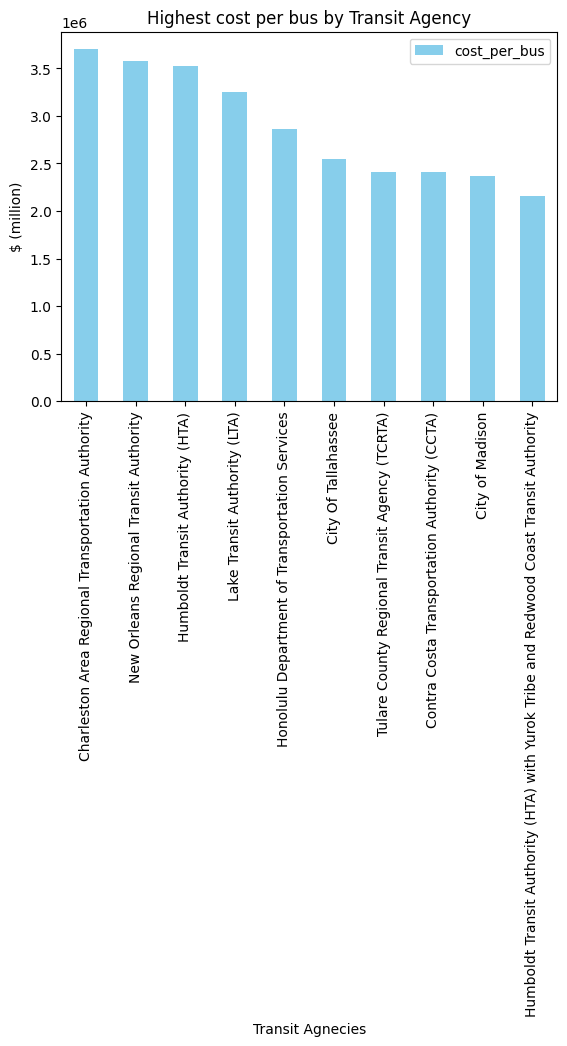

In [79]:
# highest cost per bus by agency
make_chart('cost_per_bus','Highest cost per bus by Transit Agency')

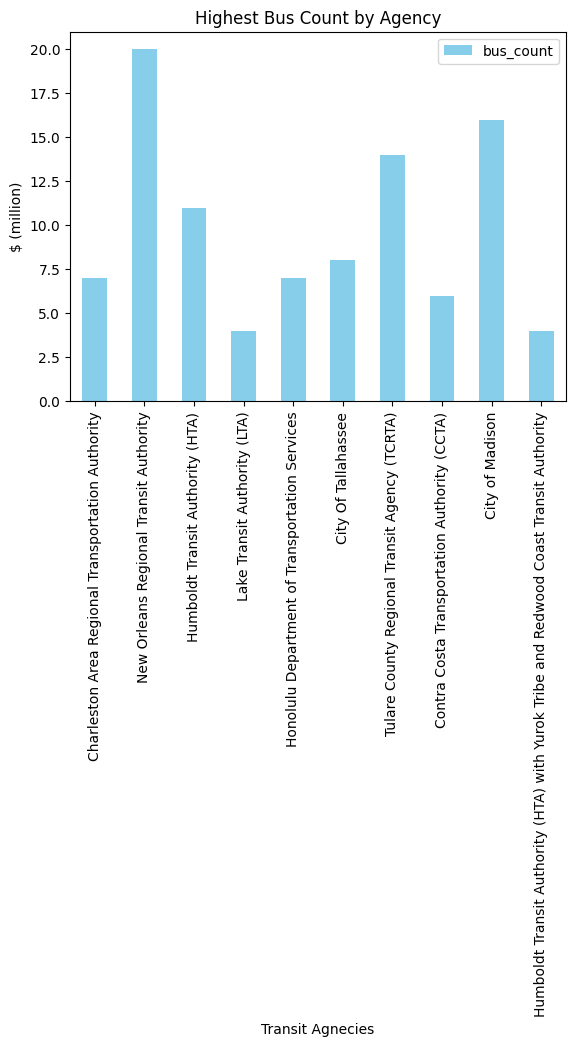

In [77]:
make_chart('bus_count', 'Highest Bus Count by Agency')

# NEED TO ADJUST FUNCTION FOR VARIABLE X Y LABELS

In [ ]:
# COST PER BUS BY PROP TYPE


In [ ]:
# bar chart of highest bus count
concat.sort_values(by="bus_count", ascending=False).head(10).plot(
    x="project_sponsor", y="bus_count", kind="bar", color="skyblue"
)
plt.title("Top 10 Agencies with most bus count")
plt.xlabel("Transit Agnecies")
plt.ylabel("# of buses")
plt.show()

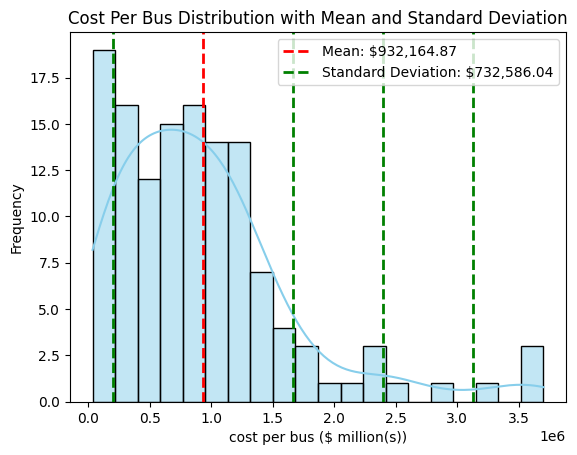

In [80]:
# distribution curve of cost per bus. no outliers
sns.histplot(filtered["cost_per_bus"], kde=True, color="skyblue", bins=20)
plt.axvline(
    mean, color="red", linestyle="dashed", linewidth=2, label=f"Mean: ${mean:,.2f}"
)
plt.axvline(
    mean + std_dev,
    color="green",
    linestyle="dashed",
    linewidth=2,
    label=f"Standard Deviation: ${std_dev:,.2f}",
)
plt.axvline(mean - std_dev, color="green", linestyle="dashed", linewidth=2)
plt.axvline(mean + std_dev * 2, color="green", linestyle="dashed", linewidth=2)
plt.axvline(mean + std_dev * 3, color="green", linestyle="dashed", linewidth=2)

plt.title("Cost Per Bus Distribution with Mean and Standard Deviation")
plt.xlabel("cost per bus ($ million(s))")
plt.ylabel("Frequency")
plt.legend()
plt.show()

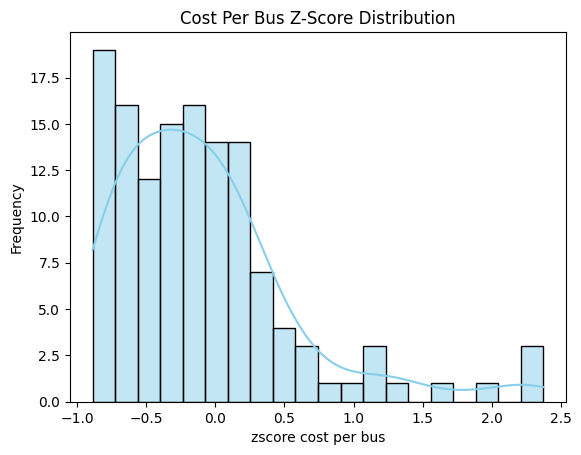

In [81]:
# distribution curve of zscore
sns.histplot(filtered["zscore_cost_per_bus"], kde=True, color="skyblue", bins=20)
# plt.axvline(mean2, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean2:.2f}')
# plt.axvline(mean2 + std_dev2, color='green', linestyle='dashed', linewidth=2, label=f'Standard Deviation: {std_dev2:,.2f}')
# plt.axvline(mean2 - std_dev2, color='green', linestyle='dashed', linewidth=2)
# plt.axvline(mean2 + (std_dev2*2), color='green', linestyle='dashed', linewidth=2)
# plt.axvline(mean2 + (std_dev2*3), color='green', linestyle='dashed', linewidth=2)
# plt.axvline(mean2 - (std_dev2*2), color='green', linestyle='dashed', linewidth=2)
# plt.axvline(mean2 - (std_dev2*3), color='green', linestyle='dashed', linewidth=2)

plt.title("Cost Per Bus Z-Score Distribution")
plt.xlabel("zscore cost per bus")
plt.ylabel("Frequency")
plt.show()